## Begin Implementation

### Calling out for Gods "Keras, scipy, numpy, mathplotlib"


In [0]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b

import numpy as np
import time

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

from google.colab import files
import os
%matplotlib inline
import matplotlib.pyplot as plt


### Basic inputs like image_size, defining path of weights to be downloaded for our vggnet

Large image sizes require a lot more time per epoch, and very large images may not even fit in GPU memory causing the OOM error(encountered generally when tried with 512) while iterating. To be safer I have choosen size 400 but you might also try 512.

In [0]:
#### inputs 


# Image size
IMAGE_SIZE = 400
# path download weights for our vggnet
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'



### Please enter your content image


Saving london-2906.jpg to london-2906 (1).jpg
Content image filename : london-2906.jpg


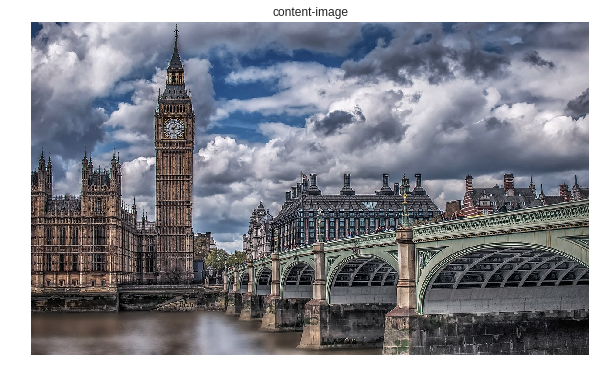

In [0]:
## uploading the image
content_img = files.upload()

CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp
  
print("Content image filename :", CONTENT_IMAGE_FN)

## displaying it
fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('content-image')
plt.imshow(img)

### Please enter the content mask if you have any

In [0]:
## uploading the image
content_mask = files.upload()

CONTENT_MASK_FN = list(content_mask)[0]
CONTENT_MASK_FN_temp = CONTENT_MASK_FN.strip().replace(" ", "_")

if CONTENT_MASK_FN != CONTENT_MASK_FN_temp:
  os.rename(CONTENT_MASK_FN, CONTENT_MASK_FN_temp)
  CONTENT_MASK_FN = CONTENT_MASK_FN_temp
  
print("content mask filename :", CONTENT_MASK_FN)

## displaying it
fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_MASK_FN)
plt.axis('off')
plt.title('content-mask')
plt.imshow(img)

### Define empty arrays for style images and their corresponding masks

In [0]:
style_reference_image_path = []

In [0]:
style_mask_path = []

### Please enter your style image

Saving Spider-Man-Costume-2906.jpg to Spider-Man-Costume-2906 (1).jpg
Style image filename : Spider-Man-Costume-2906.jpg


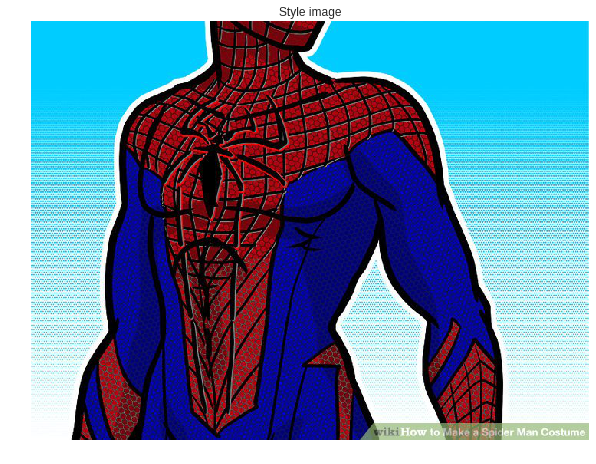

In [0]:
## upload the image
style_img = files.upload()

STYLE_IMAGE_FN1 = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN1.strip().replace(" ", "_")

if STYLE_IMAGE_FN1 != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN1, STYLE_IMAGE_FN_temp)
  STYLE_IMAGE_FN1 = STYLE_IMAGE_FN_temp
  
print("Style image filename :", STYLE_IMAGE_FN1)

## displaying it
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_IMAGE_FN1)
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

## adding it to our array for style images
style_reference_image_path.append(STYLE_IMAGE_FN1)

### Please enter the mask for the above style image if you have any.

In [0]:
## uploading the image
style_mask = files.upload()

STYLE_MASK_FN1 = list(style_mask)[0]
STYLE_MASK_FN_temp = STYLE_MASK_FN1.strip().replace(" ", "_")

if STYLE_MASK_FN1 != STYLE_MASK_FN_temp:
  os.rename(STYLE_MASK_FN1, STYLE_MASK_FN_temp)
  STYLE_MASK_FN1 = STYLE_MASK_FN_temp
  
print("style mask filename :", STYLE_MASK_FN1)

## displaying it
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_MASK_FN1)
plt.axis('off')
plt.title('style-mask-1')
plt.imshow(img)

## adding it to our array for style mask images
style_mask_path.append(STYLE_MASK_FN1)

### If you are planning for multi-style transfer then please enter the next style image

In [0]:
## uploading the image
style_img = files.upload()

STYLE_IMAGE_FN2 = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN2.strip().replace(" ", "_")

if STYLE_IMAGE_FN2 != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN2, STYLE_IMAGE_FN_temp)
  STYLE_IMAGE_FN2 = STYLE_IMAGE_FN_temp
  
print("Style image filename :", STYLE_IMAGE_FN2)

## displaying it
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_IMAGE_FN2)
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

## adding it to our array for style images
style_reference_image_path.append(STYLE_IMAGE_FN2)

### Please enter the mask for the above style image if any.

In [0]:
## uploading the image
style_mask = files.upload()

STYLE_MASK_FN2 = list(style_mask)[0]
STYLE_MASK_FN_temp = STYLE_MASK_FN2.strip().replace(" ", "_")

if STYLE_MASK_FN2 != STYLE_MASK_FN_temp:
  os.rename(STYLE_MASK_FN2, STYLE_MASK_FN_temp)
  STYLE_MASK_FN2 = STYLE_MASK_FN_temp
  
print("style mask filename :", STYLE_MASK_FN2)

## displaying it
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_MASK_FN2)
plt.axis('off')
plt.title('style-mask-2')
plt.imshow(img)

## adding it to our array for style mask images
style_mask_path.append(STYLE_MASK_FN2)

### Please make sure that you set 0 or 1 to the variables like "content_mask_present"  and "style_masks_present" as per your input

In [0]:
content_mask_present = 0
if content_mask_present == 1:
  content_mask_path = CONTENT_MASK_FN
else:
  content_mask_path = []
  
style_masks_present = 0


### Verify your inputs

In [0]:
base_image_path = CONTENT_IMAGE_FN
base_image_path

'london-2906.jpg'

In [0]:
content_mask_path

[]

In [0]:
style_reference_image_path

['Spider-Man-Costume-2906.jpg']

In [0]:
style_mask_path

[]

Before we proceed much further, we need to massage this input data to match what was done in **Simonyan and Zisserman (2015)** https://arxiv.org/abs/1409.1556, the paper that introduces the VGG Network 19-layer model that 
we intend to use.

For this, we need to perform two transformations:

*   Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).
*   Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.

Next, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [0]:
# dimensions of the generated picture.
img_width = img_height = 0

img_WIDTH = img_HEIGHT = 0
aspect_ratio = 0


In [0]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path, load_dims=False, read_mode="color"):
    global img_width, img_height, img_WIDTH, img_HEIGHT, aspect_ratio

    mode = "RGB" if read_mode == "color" else "L"
    img = imread(image_path, mode=mode)  # Prevents crashes due to PNG images (ARGB)

    if mode == "L":
        # Expand the 1 channel grayscale to 3 channel grayscale image
        temp = np.zeros(img.shape + (3,), dtype=np.uint8)
        temp[:, :, 0] = img
        temp[:, :, 1] = img.copy()
        temp[:, :, 2] = img.copy()

        img = temp

    if load_dims:
        img_WIDTH = img.shape[0]
        img_HEIGHT = img.shape[1]
        aspect_ratio = float(img_HEIGHT) / img_WIDTH

        img_width = IMAGE_SIZE
        
        img_height = int(img_width * aspect_ratio)
       

    img = imresize(img, (img_width, img_height)).astype('float32')

    # RGB -> BGR
    img = img[:, :, ::-1]

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    if K.image_dim_ordering() == "th":
        img = img.transpose((2, 0, 1)).astype('float32')

    img = np.expand_dims(img, axis=0)
    return img



In [0]:
def deprocess_image(x):
    if K.image_dim_ordering() == "th":
        x = x.reshape((3, img_width, img_height))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_width, img_height, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x



In [0]:
def load_mask(mask_path, shape):
  _, width, height, channels = shape

  mask = imread(mask_path, mode="L") # Grayscale mask load
  mask = imresize(mask, (width, height)).astype('float32')

    # Perform binarization of mask
  mask[mask <= 127] = 0
  mask[mask > 128] = 255

  max = np.amax(mask)
  mask /= max

  mask_shape = shape[1:]

  mask_tensor = np.empty(mask_shape)
        
  for i in range(channels):
    mask_tensor[:, :, i] = mask

  return mask_tensor


You have an option to choose pooling type. I have choosen maxpooling and hence set pooltype=0. It is generally observed that max pooling gives better results in most cases as compared to average pooling.

In [0]:
pooltype=0

def pooling_func(x):
    if pooltype == 1:
        return AveragePooling2D((2, 2), strides=(2, 2))(x)
    else:
        return MaxPooling2D((2, 2), strides=(2, 2))(x)


Now we're ready to use these processed inputs to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the combination image that retains the content of the content image while incorporating the style of the style image.

Next we define array called **image_tensors** which consists of all keras variables like content_image, style_images and keras placeholder combination_image

In [0]:
base_image = K.variable(preprocess_image(base_image_path, True))
style_images = []
for style_path in style_reference_image_path:
    style_images.append(K.variable(preprocess_image(style_path)))

combination_image = K.placeholder((1, img_width, img_height, 3))

image_tensors = [base_image]
for style_image_tensor in style_images:
    image_tensors.append(style_image_tensor)
image_tensors.append(combination_image)


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras model VGG19 defined below

In [0]:
nb_tensors = len(image_tensors)

## number of style images
nb_style_images = nb_tensors - 2 # Content and Output image not considered

In [0]:
input_tensor = K.concatenate(image_tensors, axis=0)

In [0]:
shape = (nb_tensors, img_width, img_height, 3)

### Let me remind you why VGGNet helps us in style transfer problem...
VGGNet is one kind of deep convnet-based image classifier which is primarily used for learning object recognition for which it has to become invariant to all image variation that’s superfluous to object identity and hence learns to encode perceptual and semantic information from the input.


In [0]:
ip = Input(tensor=input_tensor, batch_shape=shape)

# build the VGG19 network with our 3 images as input
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding='same')(ip)
x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding='same')(x)
x = pooling_func(x)

x = Convolution2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
x = Convolution2D(512, (3, 3), activation='relu', name='conv5_4', padding='same')(x)
x = pooling_func(x)

model = Model(ip, x)



The core idea introduced by Gatys et al. (2015) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the feature spaces provided by one such model to independently work with content and style of images.

since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. 

load weights corresponding to the pre-trained vgg19 image classification model

In [0]:
weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
    
model.load_weights(weights)


80142336/80134624 [==============================] - 7s 0us/step


In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'conv1_1': <tf.Tensor 'conv1_1/Relu:0' shape=(3, 400, 670, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'conv1_2/Relu:0' shape=(3, 400, 670, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'conv2_1/Relu:0' shape=(3, 200, 335, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'conv2_2/Relu:0' shape=(3, 200, 335, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'conv3_1/Relu:0' shape=(3, 100, 167, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'conv3_2/Relu:0' shape=(3, 100, 167, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'conv3_3/Relu:0' shape=(3, 100, 167, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'conv3_4/Relu:0' shape=(3, 100, 167, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'conv4_1/Relu:0' shape=(3, 50, 83, 512) dtype=float32>,
 'conv4_2': <tf.Tensor 'conv4_2/Relu:0' shape=(3, 50, 83, 512) dtype=float32>,
 'conv4_3': <tf.Tensor 'conv4_3/Relu:0' shape=(3, 50, 83, 512) dtype=float32>,
 'conv4_4': <tf.Tensor 'conv4_4/Relu:0' shape=(3, 50, 83, 512) dtype=float32>,
 'conv5_1': <tf.Tensor 'conv5_1/Relu:0

In [0]:
shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])
shape_dict

{'conv1_1': (3, 400, 670, 64),
 'conv1_2': (3, 400, 670, 64),
 'conv2_1': (3, 200, 335, 128),
 'conv2_2': (3, 200, 335, 128),
 'conv3_1': (3, 100, 167, 256),
 'conv3_2': (3, 100, 167, 256),
 'conv3_3': (3, 100, 167, 256),
 'conv3_4': (3, 100, 167, 256),
 'conv4_1': (3, 50, 83, 512),
 'conv4_2': (3, 50, 83, 512),
 'conv4_3': (3, 50, 83, 512),
 'conv4_4': (3, 50, 83, 512),
 'conv5_1': (3, 25, 41, 512),
 'conv5_2': (3, 25, 41, 512),
 'conv5_3': (3, 25, 41, 512),
 'conv5_4': (3, 25, 41, 512),
 'input_1': (3, 400, 670, 3),
 'max_pooling2d_1': (3, 200, 335, 64),
 'max_pooling2d_2': (3, 100, 167, 128),
 'max_pooling2d_3': (3, 50, 83, 256),
 'max_pooling2d_4': (3, 25, 41, 512),
 'max_pooling2d_5': (3, 12, 20, 512)}

Notice also that because we provided Keras with a concrete input tensor, the various TensorFlow tensors get well-defined shapes.

Here we're trying to reproduce the style transfer problem as an optimisation problem, where the loss function we want to minimise can be decomposed into three distinct parts: 

**content loss, style loss and total variation loss.**

The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following set have been chosen after quite a bit of experimentation.

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [0]:
# Loss Weights
content_weight = 0.025
style_weight = [5]*nb_style_images ##giving equal weight to all style images
total_variation_weight = 8.5e-05


We begin by initialising the total loss to 0 and adding to it in stages.

In [0]:
loss = K.variable(0.)


### The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

Here we draw the content feature from  conv5_2 

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

layer_features = layers['conv5_2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[nb_tensors - 1, :, :, :]

loss += content_weight * content_loss(base_image_features,
                                      combination_features)

### For style loss we need to compute gram matrix. It gets quite intricate and non-trivial here.

### What are Gram matrices and how do they help us??

They help in effective representation of textures. Textures are static and averaging over the positions is required to fully capture them. Gram matrices by performing spatial averaging nicely captures the global statistics across an image and remain blind to the arrangment of objects within the image. This idea is explained in the paper **"Incorporating Long-Range Consistency in CNN-based Texture Generation"** https://arxiv.org/abs/1606.01286


### How is Gram matrix formed?

In a particular layer of deep net, we have multiple feature maps corresponding to multiple layers. If $N_{l}$ represents number of feature maps at layer $l$ then corresponding Gram matrix is $N_{l} \mathrm{x}          N_{l}$ matrix where each positions ${i,j}$ determines how feature maps $i$ and $j$ are correlated. Diagonal terms represent the spatially averaged energy for individual feature maps and the off-diagonal terms represents the co-occurence of different features at a single spatial location.

### How does gram matrix help in computing sytle loss??

The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. Hence the matrix won't focus on specific arrangements of objects and concentrate only on texture and color

In [0]:
### improvement 1
def gram_matrix(x):
    
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features - 1 , K.transpose(features - 1))
    return gram


### The style loss is the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [0]:
def style_loss(style, combination, mask_path=None, nb_channels=None):
  if content_mask_present == 1:
    content_mask = K.variable(load_mask(content_mask_path, nb_channels))
    combination = combination * K.stop_gradient(content_mask)
    del content_mask
  
  if style_masks_present == 1:
    style_mask = K.variable(load_mask(mask_path, nb_channels))
    style = style * K.stop_gradient(style_mask)
    if content_mask_present == 0:
      combination = combination * K.stop_gradient(style_mask)
    del style_mask
    
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_width * img_height
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
  

In [0]:
style_masks = []
if style_masks_present == 1:
    style_masks = style_mask_path # If mask present, pass list of masks to style loss
else:
    style_masks = [None for _ in range(nb_style_images)] # If masks not present, pass None to the style loss

###feature_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
feature_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
                      'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']

### improvement 2  
nb_layers = len(feature_layers) - 1

for i in range(nb_layers):
    layer_features = layers[feature_layers[i]]
    shape = shape_dict[feature_layers[i]]
    style_features = layer_features[1:nb_tensors - 1, :, :, :]
    combination_features = layer_features[nb_tensors-1, :, :, :]
   
    sl1 = []
    for j in range(nb_style_images):
        sl1.append(style_loss(style_features[j], combination_features, style_masks[j], shape))

    layer_features = layers[feature_layers[i+1]]
    shape = shape_dict[feature_layers[i + 1]]
    style_features = layer_features[1:nb_tensors - 1, :, :, :]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
       
    sl2 = []
    for j in range(nb_style_images):
        sl2.append(style_loss(style_features[j], combination_features, style_masks[j], shape))

    ### improvement3     
    for j in range(nb_style_images):
        sl = sl1[j] - sl2[j]
        # Improvement 4
        # Geometric weighted scaling of style loss
        loss = loss + (style_weight[j] / (2 ** (nb_layers - (i + 1)))) * sl

 ### We include total variation loss as a regularisation term that encourages spatial smoothness. It helps to alleviate graininess in the style transferred image.
 
 You can experiment with reducing the total_variation_weight and play with the noise-level of the generated image.
 
 We have choosen total_variation_weight 0.000085 which is nearly 0 and it gives good results as per. I have also tried numbers closer to 1 but they tend to smooth out delicated details like edges in the resultant image. So for this tutorial all the 5 examples i am sticking to 8.5e-05
 

In [0]:
def total_variation_loss(x):
  a = K.square(x[:, :img_width - 1, :img_height - 1, :] - x[:, 1:, :img_height - 1, :])
  b = K.square(x[:, :img_width - 1, :img_height - 1, :] - x[:, :img_width - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

loss = loss + total_variation_weight * total_variation_loss(combination_image)

So far we have our input images massaged and our loss function calculators defined.

Next task is to define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

We start by defining the gradients.

In [0]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

Let us introduce an Evaluator class that computes loss and gradients in one pass but retrieve them via two separate functions, loss and grads. 

scipy.optimize requires separate functions for loss and gradients, and we don't want to compute the two functions separately because that would be quite inefficient.

In [0]:
outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)


In [0]:
def eval_loss_and_grads(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, img_width, img_height))
    else:
        x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values



In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()


### Solve the optimization problem

Our combination image begins its life as our content image itself.

We use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

Also I have used init_image as "content" and not "noise" since "noise" usually produces a very grainy image.

Running for 10 iterations is quite appropriate to get a considerably pleasing results. Increasing the number of iterations might help in smoothening and improving the quality of the output. I am sticking to 10 since it is a learning tutorial and the idea is easily explained in shorter runtime. Nearly each iteration takes 50s-80s on Google Colab GPU.



In [0]:
x = (preprocess_image(base_image_path, True))

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Start of iteration 0
Current loss value: 4180827600.0
Iteration 0 completed in 36s
Start of iteration 1
Current loss value: 1833687800.0
Iteration 1 completed in 30s
Start of iteration 2
Current loss value: 1255782800.0
Iteration 2 completed in 32s
Start of iteration 3
Current loss value: 993989950.0
Iteration 3 completed in 30s
Start of iteration 4
Current loss value: 846852100.0
Iteration 4 completed in 31s
Start of iteration 5
Current loss value: 744724800.0
Iteration 5 completed in 31s
Start of iteration 6
Current loss value: 679634300.0
Iteration 6 completed in 31s
Start of iteration 7
Current loss value: 627745660.0
Iteration 7 completed in 31s
Start of iteration 8
Current loss value: 582278660.0
Iteration 8 completed in 31s
Start of iteration 9
Current loss value: 552322400.0
Iteration 9 completed in 31s


Revert the intial processing done on our images using deprocess_image() function defined

In [0]:
img = deprocess_image(x.copy())

In [0]:
img1 = imresize(img, (img_WIDTH, img_HEIGHT), interp="bilinear")

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


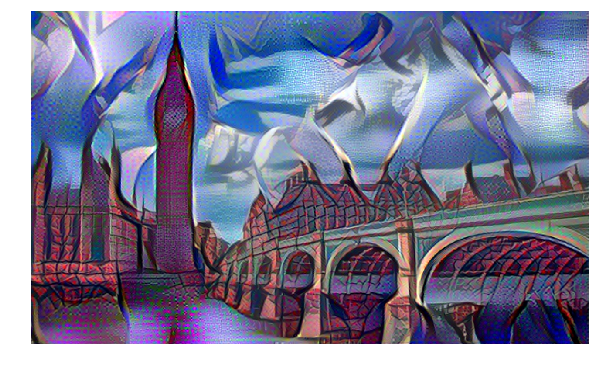

In [0]:
fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img1)

In [0]:
imsave("london+spiderman_1.jpg",img1)

In [0]:
files.download("london+spiderman_1.jpg")

### If we wish to preserve color of the content image we can follow the below steps

### Color preservation is done here by Luminance-only transfer.

For that we convert the generated image from RGB color space to YCbCr color space.
Why?
Y is the luma component of the color. Luma component is the brightness of the color. That means the light intensity of the color. The human eye is more sensitive to this component.

Cb and Cr is the blue component and red component related to the chroma component. That means “Cb is the blue component relative to the green component. Cr is the red component relative to the green component.” These components are less sensitive to the human eyes.

It is observed that visual perception is far more sensitive to changes in luminance than in color. Hence we consider performing style transfer only in the luminance channel. It is discussed in the reference paper of color preservation that this method preserves the colors of the content image perfectly.

In [0]:
# util function to preserve image color
def original_color_transform(content, generated):
    generated = fromimage(toimage(generated, mode='RGB'), mode='YCbCr')  # Convert to YCbCr color space
    generated[:, :, 1:] = content[:, :, 1:]  # Generated CbCr = Content CbCr
    generated = fromimage(toimage(generated, mode='YCbCr'), mode='RGB')  # Convert to RGB color space
    return generated

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


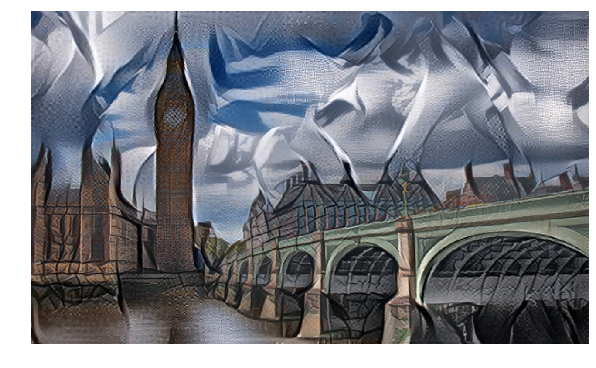

In [0]:
content = imread(base_image_path, mode="YCbCr")
content = imresize(content, (img_width, img_height))

img = original_color_transform(content, img)

img2 = imresize(img, (img_WIDTH, img_HEIGHT), interp="bilinear")

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img2)

In [0]:
imsave("london+spiderman_1+preservedcolor.jpg",img2)

In [0]:
files.download("london+spiderman_1+preservedcolor.jpg")